In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
#for each cell line, get PCs of the output of the final layer of the VNN and plot pc1 vs pc2

cell_types_df = pd.read_csv('../data/ccle_maf.txt', sep='\t')
cell_annot_df = pd.read_csv("../data/cell_line_annotations.txt", sep="\t")
cell_annot_map = dict(zip(cell_annot_df.depMapID, cell_annot_df.CCLE_ID))
cell_lines = set(pd.read_csv('../data/cell2ind.txt', sep='\t', header=None, names=['I', 'C'])['C'])
test_file_df = pd.read_csv('../data/drugcell_all.txt', sep='\t', header=None, names=['C', 'D', 'AUC'])
root_hidden_df = pd.read_csv('../hidden/NEST.hidden', sep=' ', header=None, names=['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10'])
root_hidden_df = pd.concat([test_file_df, root_hidden_df], axis=1).reindex(test_file_df.index)

In [4]:
def get_mutated_cell_lines(mut_type_list):
    mut_cell_lines = set()
    ct = cell_types_df[cell_types_df.Hugo_Symbol.isin(mut_type_list)]
    for i,row in ct.iterrows():
        if row['Broad_ID'] in cell_annot_map and cell_annot_map[row['Broad_ID']] in cell_lines:
            mut_cell_lines.add(cell_annot_map[row['Broad_ID']])
    return mut_cell_lines

In [5]:
def get_cell_lines_by_tissue_type(tissue_type):
    tissue_cl = set()
    for _,row in cell_annot_df.iterrows():
        if row['Site_Primary'] == tissue_type and row['CCLE_ID'] in cell_lines:
            tissue_cl.add(row['CCLE_ID'])
    return tissue_cl

In [11]:
def get_embedding_plot(pcs, mut_index):
    
    pc1 = pcs[:,0]
    pc2 = pcs[:,1]

    pc1_color = [pc1[i] for i in mut_index]
    pc2_color = [pc2[i] for i in mut_index]
    pc1_grey = [pc for i, pc in enumerate(pc1) if i not in mut_index]
    pc2_grey = [pc for i, pc in enumerate(pc2) if i not in mut_index]

    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(111)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(pc1_grey, pc2_grey, color = 'silver', s = 6)
    ax.scatter(pc1_color, pc2_color, color = 'green', s = 12)
    plt.show()
    return fig

In [12]:
def get_embedding_plot_contigous(pcs, mut_index, score):
    
    pc1 = pcs[:,0]
    pc2 = pcs[:,1]
    
    pc1_color = [pc1[i] for i in mut_index]
    pc2_color = [pc2[i] for i in mut_index]
    pc1_grey = [pc for i, pc in enumerate(pc1) if i not in mut_index]
    pc2_grey = [pc for i, pc in enumerate(pc2) if i not in mut_index]

    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(111)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(pc1_grey, pc2_grey, color = 'silver', s = 6)
    points = ax.scatter(pc1_color, pc2_color, c = score, cmap = 'coolwarm', s = 12)
    fig.colorbar(points)
    plt.show()
    return fig

In [8]:
root_hidden_cell_df = root_hidden_df.drop(['D', 'AUC'], 1).drop_duplicates()
hiddens = root_hidden_cell_df.drop('C', 1)

scaler = StandardScaler()
scaled_hiddens = scaler.fit_transform(hiddens)

pca = PCA()
pca.fit(scaled_hiddens)
root_hidden_pcs = pca.transform(scaled_hiddens)

n = len(root_hidden_pcs[0])
pc_df = pd.DataFrame(root_hidden_pcs[:, :n], index=root_hidden_cell_df.index)
pc_df = pd.concat([root_hidden_cell_df['C'], pc_df], axis=1).reindex(root_hidden_cell_df.index)

n = 174


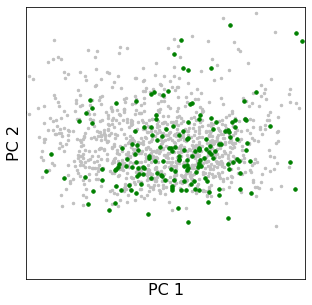

In [13]:
mut_list = ['BRAF']
braf_cell_lines = get_mutated_cell_lines(mut_list)

mut_index = [i for i, cell in enumerate(list(root_hidden_cell_df['C'])) if cell in braf_cell_lines]
print('n =', len(mut_index))

fig = get_embedding_plot(root_hidden_pcs, mut_index)

In [14]:
fig.savefig('../plots/braf_mutations.png')

n = 788


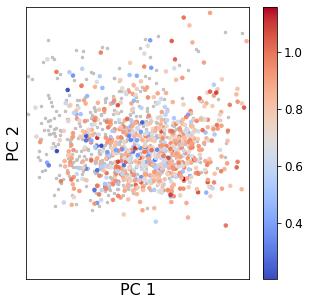

In [15]:
#Selumetinib
drug = 'CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=O)NOCCO'
root_hidden_drug_df = root_hidden_df[root_hidden_df.D == drug].drop(['D'], 1)

mut_indices = []
c_score = []

for i, cell in enumerate(list(root_hidden_cell_df['C'])):
    for idx in root_hidden_drug_df.index[root_hidden_drug_df['C'] == cell].tolist():
        c_df = root_hidden_cell_df.iloc[i].drop(['C'])
        d_df = root_hidden_drug_df.loc[idx].drop(['C', 'AUC'])
        if c_df.equals(d_df):
            mut_indices.append(i)
            c_score.append(root_hidden_drug_df.loc[idx]['AUC'])

print('n =', len(mut_indices))

fig = get_embedding_plot_contigous(root_hidden_pcs, mut_indices, c_score)

In [16]:
fig.savefig('../plots/selumetinib_embedding.png')

n = 374


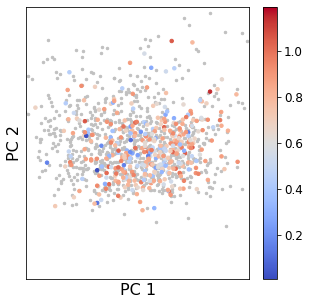

In [17]:
#Tremitinib
drug = 'CC1=C2C(=C(N(C1=O)C)NC3=C(C=C(C=C3)I)F)C(=O)N(C(=O)N2C4=CC(=CC=C4)NC(=O)C)C5CC5'
root_hidden_drug_df = root_hidden_df[root_hidden_df.D == drug].drop(['D'], 1)

mut_indices = []
c_score = []

for i, cell in enumerate(list(root_hidden_cell_df['C'])):
    for idx in root_hidden_drug_df.index[root_hidden_drug_df['C'] == cell].tolist():
        c_df = root_hidden_cell_df.iloc[i].drop(['C'])
        d_df = root_hidden_drug_df.loc[idx].drop(['C', 'AUC'])
        if c_df.equals(d_df):
            mut_indices.append(i)
            c_score.append(root_hidden_drug_df.loc[idx]['AUC'])

print('n =', len(mut_indices))

fig = get_embedding_plot_contigous(root_hidden_pcs, mut_indices, c_score)

n = 279


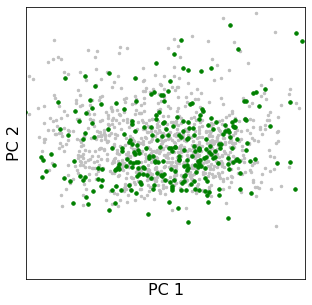

In [18]:
mut_list = ['BRAF', 'EGFR', 'LKB1']
braf_cell_lines = get_mutated_cell_lines(mut_list)

mut_index = [i for i, cell in enumerate(list(root_hidden_cell_df['C'])) if cell in braf_cell_lines]
print('n =', len(mut_index))

fig = get_embedding_plot(root_hidden_pcs, mut_index)

In [19]:
fig.savefig('../plots/braf_egfr_lkb1_embedding.png')

n = 848


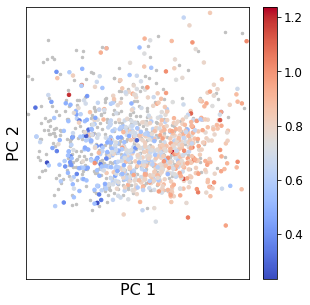

In [20]:
drug = 'CC1=C(SC2=C1C(=N[C@H](C3=NN=C(N32)C)CC(=O)OC(C)(C)C)C4=CC=C(C=C4)Cl)C'
root_hidden_drug_df = root_hidden_df[root_hidden_df.D == drug].drop(['D'], 1)

mut_indices = []
c_score = []

for i, cell in enumerate(list(root_hidden_cell_df['C'])):
    for idx in root_hidden_drug_df.index[root_hidden_drug_df['C'] == cell].tolist():
        c_df = root_hidden_cell_df.iloc[i].drop(['C'])
        d_df = root_hidden_drug_df.loc[idx].drop(['C', 'AUC'])
        if c_df.equals(d_df):
            mut_indices.append(i)
            c_score.append(root_hidden_drug_df.loc[idx]['AUC'])

print('n =', len(mut_indices))

fig = get_embedding_plot_contigous(root_hidden_pcs, mut_indices, c_score)

In [21]:
fig.savefig('../plots/JQ1_embedding.png')

n = 758


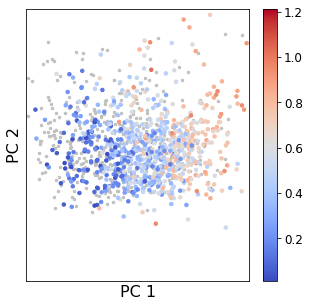

In [22]:
drug = 'CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@](C3[C@@H]([C@@](C2(C)C)(C[C@@H]1OC(=O)[C@@H]([C@H](C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)OC(=O)C'
root_hidden_drug_df = root_hidden_df[root_hidden_df.D == drug].drop(['D'], 1)

mut_indices = []
c_score = []

for i, cell in enumerate(list(root_hidden_cell_df['C'])):
    for idx in root_hidden_drug_df.index[root_hidden_drug_df['C'] == cell].tolist():
        c_df = root_hidden_cell_df.iloc[i].drop(['C'])
        d_df = root_hidden_drug_df.loc[idx].drop(['C', 'AUC'])
        if c_df.equals(d_df):
            mut_indices.append(i)
            c_score.append(root_hidden_drug_df.loc[idx]['AUC'])

print('n =', len(mut_indices))

fig = get_embedding_plot_contigous(root_hidden_pcs, mut_indices, c_score)

In [23]:
fig.savefig('../plots/paclitaxel_embedding.png')

In [137]:
cell_annot_df['Site_Primary'].unique()

array(['lung', 'large_intestine', 'haematopoietic_and_lymphoid_tissue',
       'urinary_tract', 'bone', 'skin', 'breast', 'liver', 'pleura',
       'ovary', 'oesophagus', 'endometrium', 'central_nervous_system',
       'soft_tissue', 'pancreas', 'autonomic_ganglia', 'stomach',
       'kidney', 'upper_aerodigestive_tract', 'thyroid', 'salivary_gland',
       'biliary_tract', 'prostate', 'small_intestine', nan], dtype=object)

n = 172


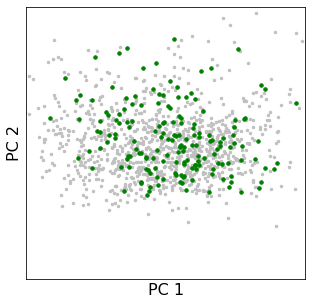

In [24]:
tissue = 'lung'
tissue_cl = get_cell_lines_by_tissue_type(tissue)

mut_index = [i for i, cell in enumerate(list(root_hidden_cell_df['C'])) if cell in tissue_cl]
print('n =', len(mut_index))

fig = get_embedding_plot(root_hidden_pcs, mut_index)

In [25]:
fig.savefig('../plots/lung_embedding.png')

n = 51


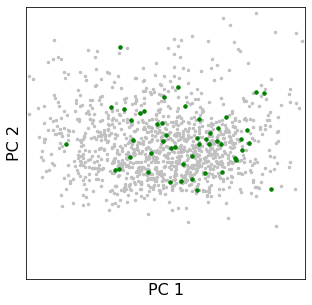

In [32]:
tissue = 'breast'
tissue_cl = get_cell_lines_by_tissue_type(tissue)

mut_index = [i for i, cell in enumerate(list(root_hidden_cell_df['C'])) if cell in tissue_cl]
print('n =', len(mut_index))

fig = get_embedding_plot(root_hidden_pcs, mut_index)

In [33]:
fig.savefig('../plots/breast_embedding.png')

n = 51


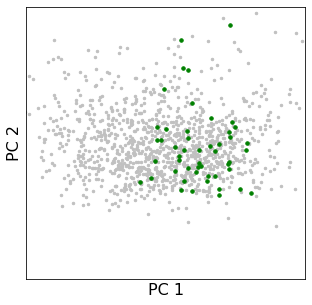

In [26]:
tissue = 'skin'
tissue_cl = get_cell_lines_by_tissue_type(tissue)

mut_index = [i for i, cell in enumerate(list(root_hidden_cell_df['C'])) if cell in tissue_cl]
print('n =', len(mut_index))

fig = get_embedding_plot(root_hidden_pcs, mut_index)

In [27]:
fig.savefig('../plots/skin_embedding.png')

n = 164


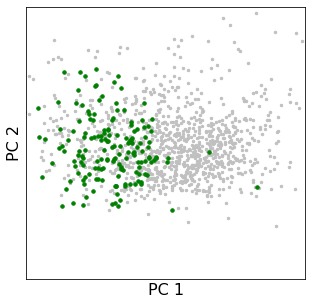

In [28]:
tissue = 'haematopoietic_and_lymphoid_tissue'
tissue_cl = get_cell_lines_by_tissue_type(tissue)

mut_index = [i for i, cell in enumerate(list(root_hidden_cell_df['C'])) if cell in tissue_cl]
print('n =', len(mut_index))

fig = get_embedding_plot(root_hidden_pcs, mut_index)

In [29]:
fig.savefig('../plots/blood_embedding.png')

n = 51


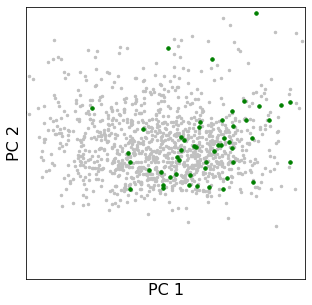

In [30]:
tissue = 'central_nervous_system'
tissue_cl = get_cell_lines_by_tissue_type(tissue)

mut_index = [i for i, cell in enumerate(list(root_hidden_cell_df['C'])) if cell in tissue_cl]
print('n =', len(mut_index))

fig = get_embedding_plot(root_hidden_pcs, mut_index)

In [31]:
fig.savefig('../plots/cns_embedding.png')